#### Date: Jun 2019<br>Programmer: Christian Dittmar, Yigitcan Özer

#### The notebook proceeds in the following steps:
<br>1. It loads an example audio file containing a clarinet recording of the C major scale.
<br>2. It computes the STFT of the audio data.
<br>3. It applies NMFD as described in [1], with audio-informed initialization of the components
<br>4. It visualizes the decomposition results.
<br>5. It resynthesizes the separated audio streams and saves them as wav files to the hard drive.
#### Reference:
[1] Christian Dittmar, Meinard Müller
<br>Reverse Engineering the Amen Break - Score-informed Separation and
<br>Restoration applied to Drum Recordings
<br>IEEE/ACM Transactions on Audio, Speech, and Language Processing,
<br>24(9): 1531-1543, 2016.

#### If you use the 'NMF toolbox' please refer to:
[2] Patricio López-Serrano, Christian Dittmar, Yiğitcan Özer, and Meinard Müller
<br>NMF Toolbox: Music Processing Applications of Nonnegative Matrix Factorization
<br>In Proceedings of the International Conference on Digital Audio Effects (DAFx), 2019.

#### License:
This file is part of 'NMF toolbox'. 'NMF toolbox' is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. 'NMF toolbox' is distributed in the hope that it will be useful, but ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

#### You should have received a copy of the GNU General Public License along<br>with 'NMF toolbox'. If not, see http://www.gnu.org/licenses/.

In [25]:
import os
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd

from NMFtoolbox.python.NMFtoolbox.forwardSTFT import forwardSTFT
from NMFtoolbox.python.NMFtoolbox.inverseSTFT import inverseSTFT
from NMFtoolbox.python.NMFtoolbox.initTemplates import initTemplates
from NMFtoolbox.python.NMFtoolbox.initActivations import initActivations
from NMFtoolbox.python.NMFtoolbox.NMF import NMF
from NMFtoolbox.python.NMFtoolbox.alphaWienerFilter import alphaWienerFilter
from NMFtoolbox.python.NMFtoolbox.visualizeComponentsNMF import visualizeComponentsNMF
from NMFtoolbox.python.NMFtoolbox.utils import make_monaural, pcmInt16ToFloat32Numpy

inpPath = 'NMFtoolbox/data/'
outPath = 'output/'

# create the output directory if it doesn't exist
if not os.path.isdir(outPath):
    os.makedirs(outPath)

# convert wav from int16 to float32
filename = 'eqt-major-sc.wav'
#filename = 'runningExample_AmenBreak.wav'

### 1. Load the audio signal

In [26]:
fs, x = wav.read(os.path.join(inpPath, filename))

# make monaural if necessary
x = make_monaural(x)

x = pcmInt16ToFloat32Numpy(x)

### 2. compute STFT

In [27]:
# spectral parameters
paramSTFT = dict()
paramSTFT['blockSize'] = 2048
paramSTFT['hopSize'] = 512
paramSTFT['winFunc'] = np.hanning(paramSTFT['blockSize'])
paramSTFT['reconstMirror'] = True
paramSTFT['appendFrame'] = True
paramSTFT['numSamples'] = len(x)

# STFT computation
X, A, P = forwardSTFT(x, paramSTFT)

# get dimensions and time and freq resolutions
numBins, numFrames = X.shape
deltaT = paramSTFT['hopSize'] / fs
deltaF = fs / paramSTFT['blockSize']

### 3. Apply NMF variants to STFT magnitude

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

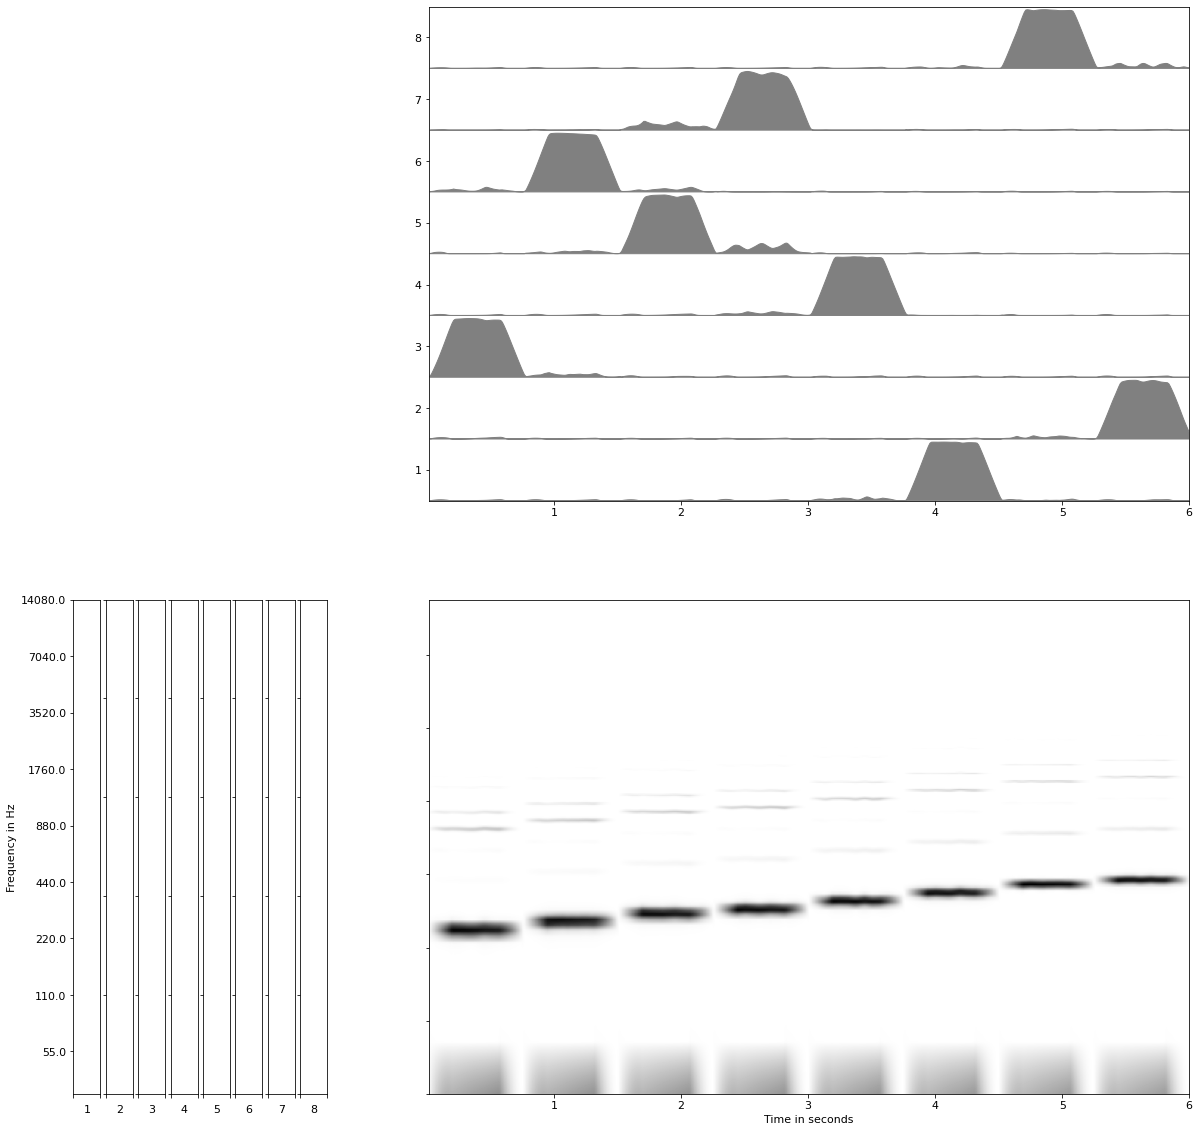

In [28]:
# set common parameters
numComp = 8
numIter = 50
numTemplateFrames = 8

# generate initial guess for templates
paramTemplates = dict()
paramTemplates['deltaF'] = deltaF
paramTemplates['numComp'] = numComp
paramTemplates['numBins'] = numBins
# paramTemplates['numTemplateFrames'] = numTemplateFrames
initW = initTemplates(paramTemplates, 'random')

# generate initial activations
paramActivations = dict()
paramActivations['numComp'] = numComp
paramActivations['numFrames'] = numFrames

initH = initActivations(paramActivations, 'uniform')

# NMF parameters
paramNMF = dict()
paramNMF['fixW'] = False
paramNMF['costFunc'] = 'EucDist'
paramNMF['reg'] = 'FrobW'
paramNMF['numComp'] = numComp
paramNMF['numFrames'] = numFrames
paramNMF['numIter'] = numIter
paramNMF['numTemplateFrames'] = numTemplateFrames
paramNMF['initW'] = np.concatenate(initW, axis=1)
paramNMF['initH'] = initH

# NMFD core method
nmfW, nmfH, nmfV = NMF(A, paramNMF)

# alpha-Wiener filtering
nmfA, _ = alphaWienerFilter(A, nmfV, 1.0)

#visualize
paramVis = dict()
paramVis['deltaT'] = deltaT
paramVis['deltaF'] = deltaF
#paramVis['endeSec'] = 3.8
#paramVis['fontSize'] = 14
fh1, _ = visualizeComponentsNMF(A, nmfW, nmfH, nmfA, paramVis)